<center>Учреждение образования</center>
<center>«Белорусский государственный университет информатики и радиоэлектроники»</center>
<br><br>
<center>Кафедра информатики</center>
<br><br><br><br><br><br><br><br><br><br>
<center>Лабораторная работа №4</center>
<center>Нейронные сети</center>
<br><br><br><br><br><br><br><br>

<p style='text-align: right;'>
Выполнил:
Полевой Александр Вадимович <br>
магистрант кафедры информатики <br>      
группа № 858641	
<br><br><br><br>
Проверил:     Стержанов Максим Валерьевич
</p>

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

<center>
Минск 2019
</center>


In [1]:
import scipy.io
import numpy as np
from itertools import chain
from scipy import optimize
import matplotlib.pyplot as plt

Набор данных ex4data1.mat (такой же, как в лабораторной работе №2) представляет собой файл формата *.mat (т.е. сохраненного из Matlab). Набор содержит 5000 изображений 20x20 в оттенках серого. Каждый пиксель представляет собой значение яркости (вещественное число). Каждое изображение сохранено в виде вектора из 400 элементов. В результате загрузки набора данных должна быть получена матрица 5000x400. Далее расположены метки классов изображений от 1 до 9 (соответствуют цифрам от 1 до 9), а также 10 (соответствует цифре 0).


**1. Загрузите данные ex4data1.mat из файла.**

In [2]:
img_data = scipy.io.loadmat('data/ex4data1.mat')

X, Y = img_data['X'], img_data['y']

In [3]:
print(f'X.shape = {X.shape}')
print(f'Y.shape = {Y.shape}')

X.shape = (5000, 400)
Y.shape = (5000, 1)


**2. Загрузите веса нейронной сети из файла ex4weights.mat, который содержит две матрицы Θ(1) (25, 401) и Θ(2) (10, 26). Какова структура полученной нейронной сети?**

In [5]:
weights_data = scipy.io.loadmat('data/ex4weights.mat')
theta1 = weights_data['Theta1']
theta2 = weights_data['Theta2']

print(f'theta1.shape = {theta1.shape}')
print(f'theta2.shape = {theta2.shape}')

theta1.shape = (25, 401)
theta2.shape = (10, 26)


In [6]:
nn_params = {
    'layer_1_input': theta1.shape[1],
    'layer_1_output': theta1.shape[0],
    'layer_2_input': theta2.shape[1],
    'layer_2_output': theta2.shape[0],
}

In [7]:
nn_params

{'layer_1_input': 401,
 'layer_1_output': 25,
 'layer_2_input': 26,
 'layer_2_output': 10}

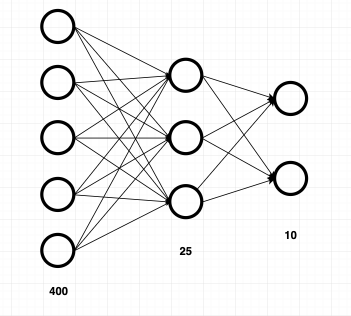

In [8]:
def unroll_thetas(thetas):
    return np.concatenate([thetas[0].flatten(), thetas[1].flatten()])

In [9]:
def rehape_thetas(unrolled_thetas):
    theta1_start = 0
    theta1_end = theta1_start + (nn_params['layer_1_input'] * nn_params['layer_1_output'])
    theta2_start = theta1_end
    theta2_end = theta2_start + (nn_params['layer_2_input'] * nn_params['layer_2_output'])

    
    theta1 = unrolled_thetas[theta1_start:theta1_end].reshape((nn_params['layer_1_output'], nn_params['layer_1_input']))
    theta2 = unrolled_thetas[theta2_start:theta2_end].reshape((nn_params['layer_2_output'], nn_params['layer_2_input']))
    
    return np.array([theta1, theta2])

In [10]:
thetas = np.array([theta1, theta2])

**3. Реализуйте функцию прямого распространения с сигмоидом в качестве функции активации.**

In [11]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

In [12]:
def add_bias_vec(a):
    return np.insert(a,0,1,axis=1)

def rm_bias(input):
    return input[:, 1:]

In [13]:
def forward_prop_vec_all(thetas, X):
    a1 = add_bias_vec(X)
    z2 = np.dot(a1, thetas[0].T)
    a2 = sigmoid(z2)
    
    a2 = add_bias_vec(a2)
    z3 = np.dot(a2, thetas[1].T)
    a3 = sigmoid(z3)

    return {'a1': a1, 'z2': z2, 'a2': a2, 'z3': z3, 'a3': a3}
    
def forward_prop_vec(thetas, X):
    return forward_prop_vec_all(thetas, X)['a3']

In [14]:
forward_prop_vec(thetas, X).shape

(5000, 10)

**4. Вычислите процент правильных классификаций на обучающей выборке. Сравните полученный результат с логистической регрессией.**

In [15]:
def predict(thetas, x):
    if x.ndim == 1:
        x = x.reshape(1, -1)
        
    fp_res = forward_prop_vec(thetas, x)
    
    return np.argmax(fp_res[0]) + 1

In [16]:
def calc_accuracy(thetas, X, Y):
    m = X.shape[0]
    correct = 0
    
    for i in range(m):
        if predict(thetas, X[i]) == Y[i]:
            correct += 1

    return correct/m

In [17]:
print("Accuracy: %0.1f%%"%(100*calc_accuracy(thetas, X, Y)))

Accuracy: 97.5%


Для лог-регрессии было 97.2%

**5. Перекодируйте исходные метки классов по схеме one-hot.**

In [18]:
def one_hot(labels):
    m = len(labels)
    uniq_labels = np.unique(labels)
    
    return (labels == uniq_labels).astype(int)

In [19]:
Y_oh = one_hot(Y)
Y_oh[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

**6. Реализуйте функцию стоимости для данной нейронной сети.**

In [21]:
def J(thetas, X, Y_one_hot, lmb = 0.):
    m = len(X)
    h = forward_prop_vec(thetas, X)
    
    e1 = np.multiply(Y_one_hot, np.log(h))
    e2 = np.multiply((1 - Y_one_hot), np.log(1 - h))
    
    regularization = 0
    cost = (-1 / m) * np.sum(e1 + e2)

    if lmb !=0:
        reg_sum = np.sum(np.power(rm_bias(thetas[0]), 2)) + np.sum(np.power(rm_bias(thetas[1]), 2))
        regularization = (lmb / (2 * m)) * reg_sum
    
    return cost + regularization

def J_unroll(unroll_thetas, X, Y_one_hot, lmb = 0.):
    return J(rehape_thetas(unroll_thetas), X, Y_one_hot, lmb)

In [22]:
J(thetas, X, Y_oh)

0.2876291651613189

In [23]:
J_unroll(unroll_thetas(thetas), X, Y_oh)

0.2876291651613189

**7. Добавьте L2-регуляризацию в функцию стоимости.**

In [24]:
J(thetas, X, Y_oh, 0.4)

0.3260854427331608

**8. Реализуйте функцию вычисления производной для функции активации.**

In [25]:
def der_sigmoid(a):
    return np.multiply(a, 1 - a)

In [26]:
der_sigmoid(np.array([1, 2, 3]))

array([ 0, -2, -6])

**9. Инициализируйте веса небольшими случайными числами.**

In [27]:
def gen_thetas(eps = 0.1):
    t1 = np.random.rand(nn_params['layer_1_output'], nn_params['layer_1_input']) * (2 * eps) - eps
    t2 = np.random.rand(nn_params['layer_2_output'], nn_params['layer_2_input']) * (2 * eps) - eps
    
    return np.array([t1, t2])

In [28]:
new_thetas = gen_thetas()

In [29]:
print("Rand thetas accuracy: %0.1f%%"%(100*calc_accuracy(new_thetas, X, Y)))

Rand thetas accuracy: 10.2%


**10. Реализуйте алгоритм обратного распространения ошибки для данной конфигурации сети.**

In [31]:
def back_prop_vec(unrolled_thetas, X, Y_one_hot, lmb = 0.):
    m = len(X)
    thetas = rehape_thetas(unrolled_thetas)
    
    delta_1 = np.zeros(thetas[0].shape)
    delta_2 = np.zeros(thetas[1].shape)

    for i in range(m):
        fp_data = forward_prop_vec_all(thetas, X[i].reshape(1, -1))
        
        d3 = fp_data['a3'] - Y_one_hot[i] # слой выхода
        
        d2 = rm_bias(np.multiply(np.dot(d3, thetas[1]), der_sigmoid(fp_data['a2'])))
        
        delta_1 += np.dot(d2.T, fp_data['a1'])
        delta_2 += np.dot(d3.T, fp_data['a2'])
    
    delta_1 /= m
    delta_2 /= m
    
    if lmb !=0:
        lmb_mult = ( lmb / m )
        delta_1[:, 1:] += lmb_mult * rm_bias(thetas[0])
        delta_2[:, 1:] += lmb_mult * rm_bias(thetas[1])
    
    return unroll_thetas(np.array([delta_1, delta_2]))

In [32]:
back_prop_thetas = back_prop_vec(unroll_thetas(thetas), X, Y_oh)
back_prop_thetas

array([ 6.18712766e-05,  0.00000000e+00,  0.00000000e+00, ...,
        9.66104721e-05, -7.57736846e-04,  7.73329872e-04])

**11. Для того, чтобы удостоверится в правильности вычисленных значений градиентов используйте метод проверки градиента с параметром ε = 10-4.**

In [33]:
def gd_check(experiments_count, unrolled_thetas, back_prop_thetas, X, Y_one_hot, lmb = 0.):
    eps = 0.0001
    theta_count = len(unrolled_thetas)
    
    for i in range(experiments_count):
        idx = int(np.random.rand() * theta_count)
        
        experiment_thetas = np.copy(unrolled_thetas)
        orig_val = experiment_thetas[idx]
        
        experiment_thetas[idx] = orig_val + eps
        cost_plus = J_unroll(experiment_thetas, X, Y_one_hot, lmb)
        
        experiment_thetas[idx] = orig_val - eps
        cost_minus = J_unroll(experiment_thetas, X, Y_one_hot, lmb)
        
        calc_g = (cost_plus - cost_minus) / (2 * eps)
        
        print(f'Idx: {idx} check gradient: {calc_g:f}, BP gradient: {back_prop_thetas[idx]:f}')
        

In [34]:
gd_check(5, unroll_thetas(thetas), back_prop_thetas, X, Y_oh, 0)

Idx: 7727 check gradient: 0.000031, BP gradient: 0.000031
Idx: 4009 check gradient: 0.000000, BP gradient: 0.000000
Idx: 9456 check gradient: -0.000018, BP gradient: -0.000018
Idx: 9600 check gradient: 0.000004, BP gradient: 0.000004
Idx: 9585 check gradient: -0.000000, BP gradient: -0.000000


**12. Добавьте L2-регуляризацию в процесс вычисления градиентов.**

In [35]:
back_prop_thetas_reg = back_prop_vec(unroll_thetas(thetas), X, Y_oh, 0.5)
back_prop_thetas_reg

array([ 6.18712766e-05, -1.05624163e-12,  2.19414684e-13, ...,
        7.18308933e-05, -6.29727728e-04,  6.40577831e-04])

**13. Проверьте полученные значения градиента.**

In [36]:
gd_check(5, unroll_thetas(thetas), back_prop_thetas_reg, X, Y_oh, 0.5)

Idx: 9248 check gradient: 0.000001, BP gradient: 0.000001
Idx: 9062 check gradient: -0.000004, BP gradient: -0.000004
Idx: 7689 check gradient: -0.000052, BP gradient: -0.000052
Idx: 9739 check gradient: -0.000153, BP gradient: -0.000153
Idx: 7132 check gradient: 0.000023, BP gradient: 0.000023


**14. Обучите нейронную сеть с использованием градиентного спуска или других более эффективных методов оптимизации.**

In [37]:
def fit(X, Y, lmb = 0., maxiter = 30):
    
    rand_thetas = gen_thetas()
    unrolled_thetas = unroll_thetas(rand_thetas)
    
    Y_one_hot = one_hot(Y)

    result = optimize.fmin_cg(maxiter=maxiter, f=J_unroll, x0=unrolled_thetas, fprime=back_prop_vec,
                                args=(X, Y_one_hot, lmb))
    out_thetas = rehape_thetas(result)
    
    return out_thetas

In [38]:
fitted_thetas = fit(X, Y, maxiter = 75)

         Current function value: 0.132333
         Iterations: 75
         Function evaluations: 184
         Gradient evaluations: 184


**15. Вычислите процент правильных классификаций на обучающей выборке.**

In [39]:
print("NN accuracy: %0.1f%%"%(100*calc_accuracy(fitted_thetas, X, Y)))

NN accuracy: 98.9%


**16. Визуализируйте скрытый слой обученной сети.**

In [40]:
def get_img_from_row(row):
    return row.reshape(20, 20).T

In [41]:
def show_images(thetas):
    
    images = thetas[0][:,1:]
    
    fig, axs = plt.subplots(5, 5, figsize=(8, 8))
    fig.subplots_adjust(wspace=0.025, hspace=0.025)
    
    axs = axs.flatten()
    
    for i in range(len(axs)):
        ax = axs[i]
        ax.imshow(get_img_from_row(images[i]), cmap='gray')
        ax.axis('off')

    plt.show()

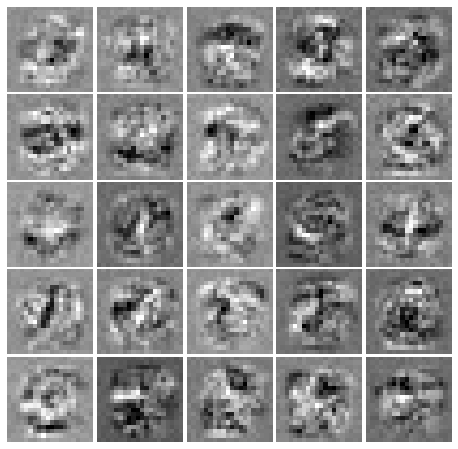

In [42]:
show_images(fitted_thetas)

**17. Подберите параметр регуляризации. Как меняются изображения на скрытом слое в зависимости от данного параметра?**

In [43]:
lambda_values = [0, 0.001, 0.01, 1., 10., 30.]

In [44]:
data_dict = {}
for i in range(len(lambda_values)):
    lmbd = lambda_values[i]
    
    t = fit(X, Y, lmb = lmbd, maxiter = 45)
    ac = calc_accuracy(t, X, Y)
    
    data_dict[str(lmbd)] = {
        'lambda': lmbd,
        'thetas': t,
        'accuracy': ac
    }

         Current function value: 0.319594
         Iterations: 45
         Function evaluations: 99
         Gradient evaluations: 99
         Current function value: 0.270704
         Iterations: 45
         Function evaluations: 108
         Gradient evaluations: 108
         Current function value: 0.319135
         Iterations: 45
         Function evaluations: 98
         Gradient evaluations: 98
         Current function value: 0.468126
         Iterations: 45
         Function evaluations: 104
         Gradient evaluations: 104
         Current function value: 1.041252
         Iterations: 45
         Function evaluations: 89
         Gradient evaluations: 89
         Current function value: 1.619401
         Iterations: 45
         Function evaluations: 90
         Gradient evaluations: 90


lambda: 0, accuracy: 0.9614


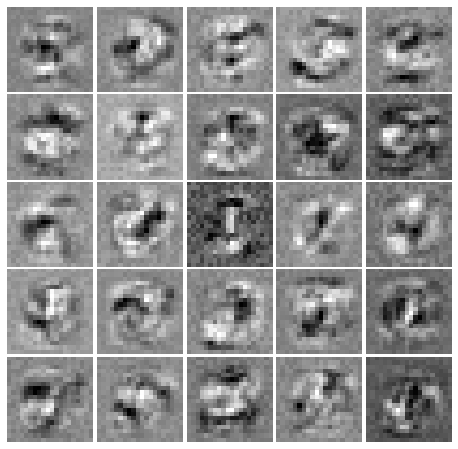

lambda: 0.001, accuracy: 0.967


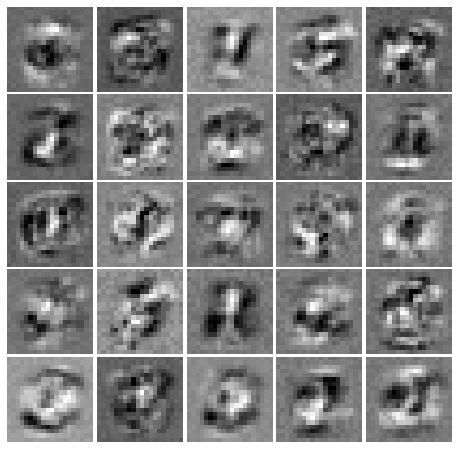

lambda: 0.01, accuracy: 0.9612


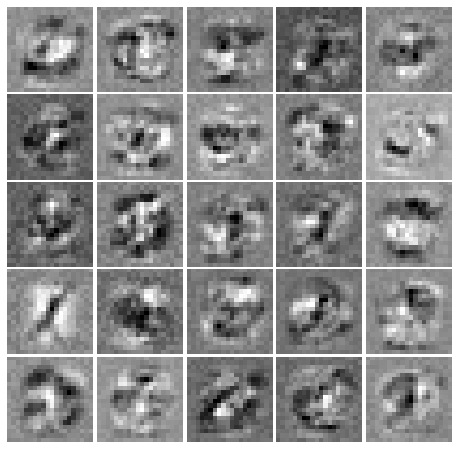

lambda: 1.0, accuracy: 0.9612


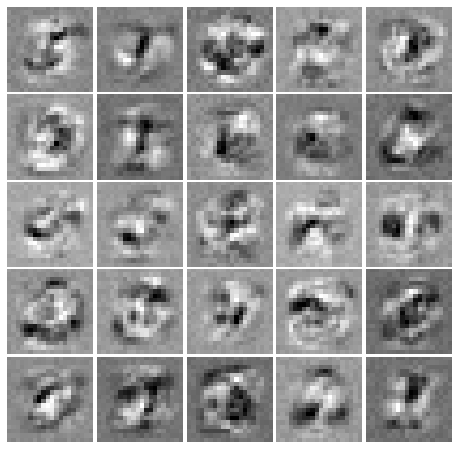

lambda: 10.0, accuracy: 0.937


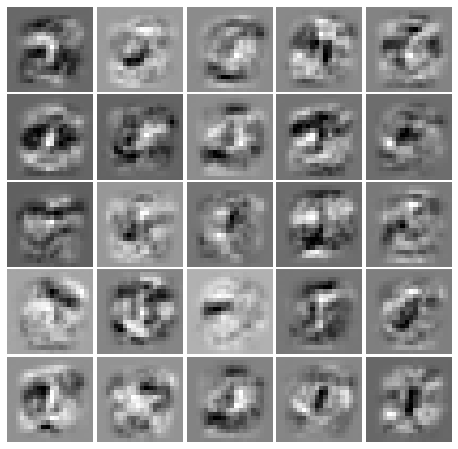

lambda: 30.0, accuracy: 0.9052


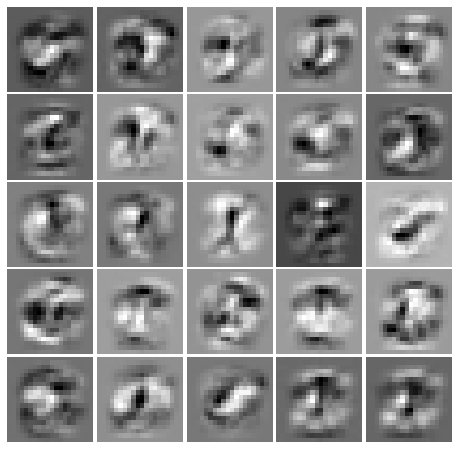

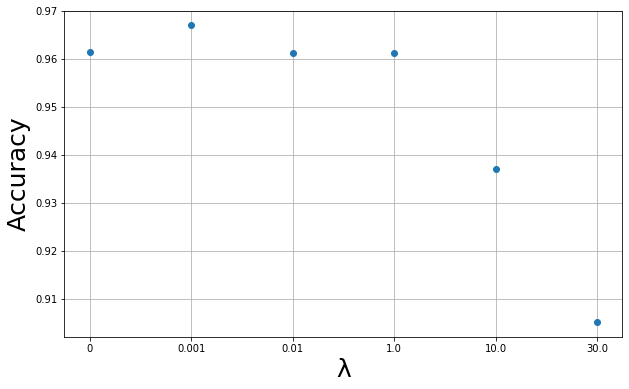

In [49]:
lambdas = []
accuracies = []

for key, value in data_dict.items():
    print(f"lambda: {key}, accuracy: {value['accuracy']}")
    lambdas.append(value['lambda'])
    accuracies.append(value['accuracy'])
          
    show_images(value['thetas'])
    
xVals = np.arange(len(lambdas))

plt.figure(figsize=(10,6))
plt.plot(xVals, accuracies, 'o')
plt.grid(True)
plt.xlabel("\u03BB", fontsize=25)
plt.ylabel("Accuracy", fontsize=25)
plt.xticks(xVals, lambdas)
plt.show()

**Вывод** 

Нейрон - узел искусственной нейронной сети, являющийся упрощённой моделью естественного нейрона. Математически, искусственный нейрон обычно представляют как некоторую нелинейную функцию от единственного аргумента — линейной комбинации всех входных сигналов. Данную функцию называют функцией активации или функцией срабатывания, передаточной функцией. Полученный результат посылается на единственный выход. Такие искусственные нейроны объединяют в сети — соединяют выходы одних нейронов с входами других.

Нейронные сети используются для решения сложных задач, которые требуют большого числа аналитических вычислений (похожих на выполняемые человеческим мозгом). 

Основные области применения: 
- Предсказание
- Классификация 
- Распознавание